In [1]:
from portiloopml.portiloop_python.ANN.data.mass_data_new import MassDataset, SubjectLoader
import os

In [2]:
dataset_path = '/project/MASS/mass_spindles_dataset'

subject_loader = SubjectLoader(
    os.path.join(dataset_path, 'subject_info.csv'))
subjects = subject_loader.select_subjects_age(18, 40, num_subjects=3)
subjects += subject_loader.select_subjects_age(40, 100, num_subjects=3)

dataset = MassDataset(
        dataset_path,
        subjects=subjects,
        window_size=54,
        seq_stride=42,
        seq_len=1,
        use_filtered=False)

Time taken to load 01-03-0020: 3.3609066009521484
Time taken to load 01-05-0013: 3.3960001468658447
Time taken to load 01-03-0022: 3.9855189323425293
Time taken to load 01-03-0009: 1.0190749168395996
Time taken to load 01-01-0028: 3.7708077430725098
Time taken to load 01-01-0036: 3.959338903427124
Time taken to create lookup table: 6.265508413314819
Number of sampleable indices: 46742682
Number of spindle indexes: 595002
Number of spindles: 3043
Number of N1 indexes: 3912500
Number of N2 indexes: 19900000
Number of N3 indexes: 5775000
Number of R indexes: 6507500
Number of W indexes: 8400000


In [4]:
from wonambi.detect.spindle import DetectSpindle, detect_Lacourse2018
import numpy as np

In [5]:
def offline_detect(data, freq, mask):
    # Extract only the interesting elements from the mask
    data_masked = data[mask]

    # Get the spindle data from the offline methods
    time = np.arange(0, len(data)) / freq
    time_masked = time[mask] 
    detector = DetectSpindle(method='Lacourse2018')
    spindles, _, _ = detect_Lacourse2018(data_masked, freq, time_masked, detector)

    return spindles

In [58]:
subject = subjects[0]


In [61]:
len(events_indices)

1159

In [82]:
import time
from portiloopml.portiloop_python.ANN.wamsley_utils import binary_f1_score

metrics = {}
for subject in subjects:

    print(f"Detecting spindles for subject {subject}...")
    start = time.time()
    signal = dataset.data[subject]['signal']
    ss_labels = dataset.data[subject]['ss_label']
    mask = (ss_labels == 1) | (ss_labels == 2)
    events = offline_detect(signal, 250, mask)
    events_onsets = [int(event['start']*250) for event in events]
    print(f"    Detection took {time.time() - start} seconds")

    # Iterate through the signal using a sliding window
    start = 0
    length = 60 * 250 * 60  # 10 minutes
    events_small = []
    events_small_onsets = []
    for i in range(0, len(signal), length):
        signal_small = signal[i:i + length] if i + length < len(signal) else signal[i:]
        mask_small = mask[i:i + length] if i + length < len(signal) else mask[i:]
        print(f"    Detecting from index {i} to {i + length}...")
        if sum(mask_small) == 0:
            print("     No spindles in this window")
            continue
        
        start = time.time()
        _events = offline_detect(signal_small, 250, mask_small)
        print(f"    Detection took {time.time() - start} seconds")
        print(f"    Found {len(_events)} events")
        events_small += _events
        events_small_onsets += [int(e['start'] * 250) + i for e in _events]

    scores = binary_f1_score(np.array(events_onsets), np.array(events_small_onsets), 250)

    metrics[subject] = {
        'events_onsets': events_onsets,
        'events_small_onsets': events_small_onsets,
        'scores': scores
    }


Detecting spindles for subject 01-03-0020...
    Detection took 101.88570880889893 seconds
    Detecting from index 0 to 900000...
    Detection took 4.509457349777222 seconds
    Found 72 events
    Detecting from index 900000 to 1800000...
    Detection took 13.063392877578735 seconds
    Found 189 events
    Detecting from index 1800000 to 2700000...
     No spindles in this window
    Detecting from index 2700000 to 3600000...
    Detection took 17.123488664627075 seconds
    Found 240 events
    Detecting from index 3600000 to 4500000...
    Detection took 13.241858959197998 seconds
    Found 83 events
    Detecting from index 4500000 to 5400000...
    Detection took 17.13262629508972 seconds
    Found 171 events
    Detecting from index 5400000 to 6300000...
    Detection took 15.513920307159424 seconds
    Found 197 events
    Detecting from index 6300000 to 7200000...
    Detection took 9.768331527709961 seconds
    Found 158 events
    Detecting from index 7200000 to 8100000..

In [85]:
for subject in metrics:
    print(f"Subject {subject}:")
    print(f"    F1 score: {metrics[subject]['scores']}")

Subject 01-03-0020:
    F1 score: (0.882258064516129, 0.9439171699741156, 0.9120466811249163, 1094, 146, 65, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 950, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 25, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 175, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 425, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 50, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 25, 0, 0, 175, 0, 25, 25, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 2200, 25, 250, 0, 0, 0, 0, 0, 25, 25, 0, 0, 0, 0, 0, 0, 150, 0, 0, 50, 750, 0, 0, 0, 

In [88]:
metrics_no_mask = {}
for subject in subjects:

    print(f"Detecting spindles for subject {subject}...")
    start = time.time()
    signal = dataset.data[subject]['signal']
    ss_labels = dataset.data[subject]['ss_label']
    mask = ss_labels < 10
    events = offline_detect(signal, 250, mask)
    events_onsets = [int(event['start']*250) for event in events]
    print(f"    Detection took {time.time() - start} seconds")

    # Iterate through the signal using a sliding window
    start = 0
    length = 60 * 250 * 60  # 10 minutes
    events_small = []
    events_small_onsets = []
    for i in range(0, len(signal), length):
        signal_small = signal[i:i + length] if i + length < len(signal) else signal[i:]
        mask_small = mask[i:i + length] if i + length < len(signal) else mask[i:]
        print(f"    Detecting from index {i} to {i + length}...")
        if sum(mask_small) == 0:
            print("     No spindles in this window")
            continue
        
        start = time.time()
        _events = offline_detect(signal_small, 250, mask_small)
        print(f"    Detection took {time.time() - start} seconds")
        print(f"    Found {len(_events)} events")
        events_small += _events
        events_small_onsets += [int(e['start'] * 250) + i for e in _events]

    scores = binary_f1_score(np.array(events_onsets), np.array(events_small_onsets), 250)

    metrics[subject] = {
        'events_onsets': events_onsets,
        'events_small_onsets': events_small_onsets,
        'scores': scores
    }

Detecting spindles for subject 01-03-0020...
    Detection took 195.0325963497162 seconds
    Detecting from index 0 to 900000...
    Detection took 21.182579040527344 seconds
    Found 172 events
    Detecting from index 900000 to 1800000...
    Detection took 21.378600358963013 seconds
    Found 246 events
    Detecting from index 1800000 to 2700000...
    Detection took 21.390658378601074 seconds
    Found 217 events
    Detecting from index 2700000 to 3600000...
    Detection took 21.346125841140747 seconds
    Found 256 events
    Detecting from index 3600000 to 4500000...
    Detection took 21.135556936264038 seconds
    Found 107 events
    Detecting from index 4500000 to 5400000...
    Detection took 21.209394454956055 seconds
    Found 192 events
    Detecting from index 5400000 to 6300000...
    Detection took 21.570308685302734 seconds
    Found 209 events
    Detecting from index 6300000 to 7200000...
    Detection took 21.442323207855225 seconds
    Found 192 events
    De

/home/ubuntu/anaconda3/envs/portiloop-training/lib/python3.11/site-packages/wonambi/detect/spindle.py:1521: RuntimeWarning: divide by zero encountered in scalar divide
  out[i] = (dat[i] - mean(windat)) / std(stddat)
/home/ubuntu/anaconda3/envs/portiloop-training/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/anaconda3/envs/portiloop-training/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ubuntu/anaconda3/envs/portiloop-training/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


    Detection took 193.35792660713196 seconds
    Detecting from index 0 to 900000...
    Detection took 21.380316495895386 seconds
    Found 139 events
    Detecting from index 900000 to 1800000...
    Detection took 21.407055616378784 seconds
    Found 67 events
    Detecting from index 1800000 to 2700000...
    Detection took 21.230564832687378 seconds
    Found 91 events
    Detecting from index 2700000 to 3600000...
    Detection took 21.597140550613403 seconds
    Found 63 events
    Detecting from index 3600000 to 4500000...
    Detection took 21.5668363571167 seconds
    Found 71 events
    Detecting from index 4500000 to 5400000...
    Detection took 21.295010566711426 seconds
    Found 32 events
    Detecting from index 5400000 to 6300000...
    Detection took 21.430812120437622 seconds
    Found 0 events
    Detecting from index 6300000 to 7200000...
    Detection took 21.324143886566162 seconds
    Found 128 events
    Detecting from index 7200000 to 8100000...
    Detectio

In [92]:
for subject in metrics:
    print(f"Subject {subject}:")
    print(f"    F1 score: {metrics[subject]['scores']}")

Subject 01-03-0020:
    F1 score: (0.8058086560364465, 0.9111397295556987, 0.8552432709329912, 1415, 341, 138, [0, 25, 0, 25, 25, 0, 0, 0, 0, 25, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 400, 25, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 25, 25, 0, 0, 0, 25, 0, 0, 0, 0, 25, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 50, 0, 0, 0, 0, 25, 25, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 300, 0, 275, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 25, 0, 0, 0, 25, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 200, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 1350, 0, 0, 0, 0, 50, 25, 

In [93]:
# Visualy checking the spindles of one subject
signal = dataset.data[subject]['signal']
ss_labels = dataset.data[subject]['ss_label']
mask = (ss_labels == 1) | (ss_labels == 2)
events = offline_detect(signal, 250, mask)
events_onsets = [int(event['start']*250) for event in events]
length = 15 * 250
spindles = [signal[i-length:i+length] for i in events_onsets]

In [158]:
spindles = [[int(event['start'] * 250), int(event['peak_time'] * 250), int(event['end'] * 250)] for event in events]

In [94]:
import matplotlib.pyplot as plt

In [95]:
index = 0

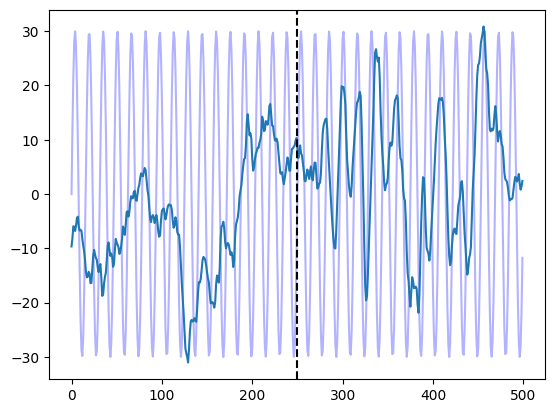

In [152]:
# plot a 16 hz sine wave
sine_wave = np.sin(2 * np.pi * 16 * np.arange(0, 2, 1/250)) * 30
plt.plot(sine_wave, label='16 Hz Sine Wave', color='blue', alpha=0.3)
spindle = spindles[index]
plt.plot(spindle[len(spindle)//2-250:len(spindle)//2+250])
plt.axvline(x=250, color='black', linestyle='--')
index += 1